# Retrieval Augmented Generation

From the Anthropic CookBook:\
"Claude excels at a wide range of tasks, but it may struggle with queries specific to your unique business context. This is where Retrieval Augmented Generation (RAG) becomes invaluable. RAG enables Claude to leverage your internal knowledge bases or customer support documents, significantly enhancing its ability to answer domain-specific questions."

In this notebook, relying on the Anthropic CookBook examples we are:

1) Setting up a basic RAG system using an in-memory vector database and embeddings from [Voyage AI](https://www.voyageai.com/).

2) Building a robust evaluation suite, measuring the retrieval pipeine & end to end performance independently.


## Table of Contents

1) Setup

2) Basic RAG

3) Evaluation


## 1 - Setup

We'll need a few libraries, including:

1) `anthropic` - to interact with Claude

2) `voyageai` - to generate high quality embeddings

3) `pandas`, `numpy`, `matplotlib`, and `scikit-learn` for data manipulation and visualization


You'll also need API keys from [Anthropic](https://www.anthropic.com/) and [Voyage AI](https://www.voyageai.com/)

In [4]:
## setup
!pip install anthropic
!pip install voyageai
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install PyMuPDF
!pip install pytesseract Pillow
!pip install PyPDF2
!pip install tiktoken
!pip install pdf2image pytesseract
!pip install pillow
!pip install ragas
!pip install langchain
!pip install torch
!pip install sentence-transformers
!pip install transformers
!pip install evaluate
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --up

Setting up API keys: 

In [36]:
# Set up API keys from .env file, or if using locally - you can also set them directly here underneath
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['VOYAGE_API_KEY'] = os.getenv("VOYAGE_API_KEY")
os.environ['ANTHROPIC_API_KEY'] = os.getenv("ANTHROPIC_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

# If using locally, uncomment the following lines and insert your API keys
# os.environ['VOYAGE_API_KEY'] = "insert_your_voyage_api_key_here"
# os.environ['ANTHROPIC_API_KEY'] = "insert_your_anthropic_api_key_here"
# os.environ['OPENAI_API_KEY'] = "insert_your_openai_api_key_here"


Importing all relevant libraries for this notebook:

In [6]:
# Standard library imports
import json
import logging
import os
import pickle
import xml.etree.ElementTree as ET
from typing import Callable, List, Dict, Any, Tuple, Set
from dataclasses import dataclass, field  # Add this import
from pathlib import Path
import re
from dataclasses import dataclass, field

# Third-party data processing & scientific computing
import numpy as np
import pandas as pd
from numpy.linalg import norm
from collections import defaultdict


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# PDF and image processing
import fitz
import pytesseract
from PIL import Image
import io
from PyPDF2 import PdfReader
import PyPDF2
import pytesseract
from pdf2image import convert_from_path
from PIL import Image


# Progress bars and utilities
from tqdm import tqdm

# AI/ML specific libraries
import anthropic
from anthropic import Client
import tiktoken
#RAG
import ragas.metrics as rm
from ragas import evaluate, EvaluationDataset, RunConfig
from datasets import load_dataset
from ragas.metrics import faithfulness, answer_correctness, answer_relevancy, context_precision
import voyageai

import time
import openai
import random

Define domain dictionary for better indexing of embedded content:

In [7]:
# This is a list of headers that are used consistently in all planning documents.

headers_dict = {
    "1.": "זיהוי וסיווג התכנית",
    "1.1": "שם התכנית ומספר התכנית",
    "1.2": "שטח התכנית",
    "1.4": "סיווג התכנית",
    "1.5": "מקום התכנית",
    "1.5.1": "נתונים כלליים",
    "1.5.2": "תיאור מקום",
    "1.5.3": "רשויות מקומיות בתכנית והתייחסות",
    "1.5.4": "כתובות שבהן חלה התכנית",
    "1.5.5": "גושים וחלקות בתכנית", 
    "1.5.6": "גושים ישנים",
    "1.5.7": "מגרשים / תאי שטח מתכניות קודמות שלא נרשמו כחלקות",
    "1.5.8": "מרחבי תכנון גובלים בתכנית",
    "1.6": "יחס בין התכנית לבין תכניות מאושרות קודמות",
    "1.7": "מסמכי התכנית",
    "1.8": "בעלי עניין",
    "1.8.1": "מגיש התכנית",
    "1.8.2": "יזם",
    "1.8.4": "עורך התכנית ובעלי מקצוע",
    "1.9": "הגדרות בתכנית",
    "2.": "מטרת התכנית",
    "2.2": "עיקרי הוראות התכנית",   
    "3.": "טבלת יעודי קרקע ותאי שטח בתכנית",
    "3.2": "טבלת שטחים",
    "4.": "יעודי קרקע ושימושים", #maybe can be later more granular with a sequence of the different land uses - 4.2,4.3,.. etc
    "5.": "טבלת זכויות והוראות בניה", 
    "6.": "הוראות נוספות", #same
    "7.": "ביצוע"
    }

# Defines text patterns to ignore when processin the documents (e.g., page numbers, printing counters, etc.)

ignore_patterns = [
    r"\d+\sמונה\sהדפסה",               # Matches "number מונה הדפסה"
    r"^\s*תכנון זמין\s*$",              # Matches a line with only "תכנון זמין" and optional whitespace
    r".*מועד הפקה\s*$",
    r"שם התכנית:\s.*$"
]

# Defines domain terminology that is used in the planning documents.
# This is a dictionary that contains the primary term, its variations, related terms, and relevant chunks of text where it can be found (optional).

PLANNING_TERMS = {
    'housing': {
        'primary': 'יחידות דיור',
        'abbreviations': ['יח"ד', 'יח״ד'],
        'variations': ['דירות', 'יחידות מגורים'],
        'related': ['מגורים'],
        'relevant_chunks': [
            'Introductory Section',
            'מטרת התכנית',
            'עיקרי הוראות התכנית',
            'טבלת יעודי קרקע ותאי שטח בתכנית',
            'טבלת שטחים',
            'יעודי קרקע ושימושים',
            'טבלת זכויות והוראות בניה',
            'הוראות נוספות'
            ]
    },
    'affordable':{
        'primary': 'בר השגה',
        'variations': ['דב"י', 'בהישג יד', 'דב״י'],
        'related': ['מגורים', 'יחידות דיור', 'יח"ד', 'להשכרה', 'בשכירות', 'בעלות המדינה'],
    },
    'density': {
        'primary': 'צפיפות',
        'variations': ['יח"ד לדונם', 'יחידות דיור לדונם'],
        'related': ['מספר יחידות', 'עצימות', 'רח"ק'],
        'relevant_chunks':
        ['Introductory Section',
         'מטרת התכנית',
         'עיקרי הוראות התכנית',
         'טבלת יעודי קרקע ותאי שטח בתכנית',
         'טבלת שטחים',
         'יעודי קרקע ושימושים',
         'טבלת זכויות והוראות בניה',
         'הוראות נוספות'
         ]
    }
}

In [8]:
# Function to count tokens in a text, for optimizing API calls and ensuring compliance with token limits.

def count_tokens_locally(text):
    encoding = tiktoken.get_encoding("cl100k_base")  # Close to Claude's tokenization
    return len(encoding.encode(text))

### Initialize a Vector DB Class

An in-memory vector DB (for a production application, a hosted solution may be necessary). 

In [16]:
class VectorDB:
    #Define model name & max token limit 
    MODEL_NAME = "voyage-3-lite"
    MAX_TOKENS = 32000

    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.normalized_embeddings = []
        self.query_cache = {}
        self.db_path = f"./{name}/vector_db.pkl"

    def load_data(self, chunks):
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        # Build the metadata dictionary and extract texts from the source chunks.
        metadata_list = []
        texts = []
        for chunk in chunks:
            # Construct a metadata dictionary for each chunk
            chunk_metadata = {
                "chunk_id": chunk.get("chunk_id"),
                "plan_number": chunk.get("plan_number"),
                "year": chunk.get("year"),  # date of the version online
                "chunk_heading": chunk.get("chunk_heading"),
                "text": chunk.get("text"),  # the original text chunk
                "source_file": chunk.get("source_file"),
                "document_type": chunk.get("document_type")
            }
            metadata_list.append(chunk_metadata)
            # Use only the text for embedding
            texts.append(chunk.get("text"))

        self.metadata = metadata_list
        # Pass the texts to the embed function.
        self._embed_and_store(texts)
        self.save_db()
        print("Vector database loaded and saved.")

    def _embed_and_store(self, texts):
        self.embeddings = []  

        batch = []           # Current batch of texts to embed
        batch_tokens = 0     # Token counter for the current batch
        all_embeddings = []  # Final list of embeddings


        # Iterate over the texts in the provided order
        for text in texts:
            # Calculate token count for this text
            text_tokens = count_tokens_locally(text)
            
            # If adding this text would exceed the token limit, embed the current batch first
            if batch_tokens + text_tokens > self.MAX_TOKENS:
                if batch:
                    response = self.client.embed(batch, model=self.MODEL_NAME)
                    all_embeddings.extend(response.embeddings)
                # Reset the batch variables
                batch = []
                batch_tokens = 0
            
            # Add the text to the current batch and update token count
            batch.append(text)
            batch_tokens += text_tokens

        # Process any remaining texts in the final batch
        if batch:
            response = self.client.embed(batch, model=self.MODEL_NAME)
            all_embeddings.extend(response.embeddings)

        # Store the embeddings—order is preserved to match your metadata list from load_data
        self.embeddings = all_embeddings

    def identify_planning_concepts(self, query: str) -> list[str]:
        """
        Identifies which planning concepts are relevant to the query.
        Args:
            query (str): The search query
            
        Returns:
            list[str]: List of relevant planning concepts
        """
        matching_concepts = []
        
        for concept, terms in PLANNING_TERMS.items():
            if (terms['primary'] in query or 
                any(abbr in query for abbr in terms.get('abbreviations', [])) or
                any(var in query for var in terms.get('variations', [])) or
                any(rel in query for rel in terms.get('related', []))):
                matching_concepts.append(concept)
                
        print(f"DEBUG: Identified planning concepts: {matching_concepts}")
        return matching_concepts

    def expand_query_with_planning_terms(self, query):
        query_terms = set()
        for category, terms in PLANNING_TERMS.items():
            all_terms = ([terms['primary']] + 
                        terms.get('abbreviations', []) +
                        terms.get('variations', []) +
                        terms.get('related', []))
            
            if any(term in query for term in all_terms):
                query_terms.update(all_terms)
        return list(query_terms)
    

    def search_by_plan(self, query, top_k=10, similarity_threshold=0.2):
        """
        Search for relevant chunks across all plans, prioritizing exact matches of planning terms and their relevant chunks.
        If exact matches are found, we compute a combined score (average of cosine similarity and term match ratio).
        Otherwise, we fall back to a similarity-only search and group by plan.
        """
        # Get or compute the query embedding
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model=self.MODEL_NAME).embeddings[0]
            self.query_cache[query] = query_embedding
        print(f"DEBUG: Query is {query}")

        embeddings_array = np.array(self.embeddings)
        norms = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
        self.normalized_embeddings = embeddings_array / (norms + 1e-8)

        # Normalize the query embedding
        query_norm = np.linalg.norm(query_embedding)
        normalized_query = query_embedding / (query_norm + 1e-8)
        
        # print("\nDEBUG START OF SEARCH")
        # print(f"Query: {query}")

        # Step 1: Expand the query into planning terms for exact matching
        query_terms = self.expand_query_with_planning_terms(query)
        # print(f"\nDebug: Expanded query terms: {query_terms}")
        
        exact_matches = []
        
        for idx, metadata in enumerate(self.metadata):
            chunk_text = metadata.get("text", "")
            matched_terms = [term for term in query_terms if term in chunk_text]
            term_count = len(matched_terms)
            
            if term_count > 0:
                exact_matches.append({
                    "idx": idx,
                    "metadata": metadata,
                    "term_count": term_count,
                    "matched_terms": matched_terms
                })
        
        print(f"\nDebug: Found {len(exact_matches)} chunks with exact term matches")
        
        # If exact matches exist, use them to compute a combined score.
        if exact_matches:
            plan_best_chunks = defaultdict(list)

            # Get the global indices of exact matches
            filtered_indices = np.array([match["idx"] for match in exact_matches])
            normalized_embeddings = np.array(self.normalized_embeddings)  # Ensure it's a NumPy array
            filtered_embeddings = normalized_embeddings[filtered_indices]
            
            # Compute cosine similarities for the filtered chunks
            similarities = np.dot(filtered_embeddings, normalized_query)
            # Sort them in descending order of similarity
            sorted_order = np.argsort(similarities)[::-1]
            
            for local_idx in sorted_order:
                similarity = similarities[local_idx]
                if similarity < similarity_threshold:
                    continue  # Skip chunks below threshold
                # Convert local filtered index to global index
                orig_idx = filtered_indices[local_idx]
                metadata = self.metadata[orig_idx]
                term_count = exact_matches[local_idx]["term_count"]
                # Compute a combined score: average of cosine similarity and term match ratio
                combined_score = (similarity + (term_count / len(query_terms))) / 2
                
                chunk_info = {
                        "metadata": metadata,
                        "similarity": similarity,
                        "term_count": term_count,
                        "matched_terms": exact_matches[local_idx]["matched_terms"],
                        "combined_score": combined_score
                    }
                plan_number = metadata.get("plan_number", "N/A")
                plan_best_chunks[plan_number].append(chunk_info)
            # For each plan, keep only the top_k chunks (sorted by combined_score)
            for pnum in plan_best_chunks:
                plan_best_chunks[pnum].sort(key=lambda x: x["combined_score"], reverse=True)
                plan_best_chunks[pnum] = plan_best_chunks[pnum][:top_k]
            # Flatten into a single list of chunks (if you want them all together)
            results = []
            for chunk_list in plan_best_chunks.values():
                results.extend(chunk_list)
            results.sort(key=lambda x: x["combined_score"], reverse=True)  

        else:
            print("\nDebug: No exact matches found, falling back to similarity search")
            similarities = np.dot(self.normalized_embeddings, normalized_query)
            plan_best_chunks = defaultdict(list)
            sorted_indices = np.argsort(similarities)[::-1]

            for idx in np.argsort(similarities)[::-1]:
                similarity = similarities[idx]
                if similarity < similarity_threshold:
                    break
                metadata = self.metadata[idx]
                plan_number = metadata.get("plan_number", "N/A")
                chunk_info = {
                        "metadata": metadata,
                        "similarity": similarity,
                    }
                plan_best_chunks[plan_number].append(chunk_info)
           # Keep only top_k chunks per plan
            for pnum in plan_best_chunks:
                plan_best_chunks[pnum].sort(key=lambda x: x["similarity"], reverse=True)
                plan_best_chunks[pnum] = plan_best_chunks[pnum][:top_k]
            
            results = []
            for chunk_list in plan_best_chunks.values():
                results.extend(chunk_list)
            results.sort(key=lambda x: x["similarity"], reverse=True)
            
        return results

    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

    def get_all_plan_numbers(self, all_chunks):
        """
        Extracts and returns a list of all unique plan numbers from the all_chunks variable.
        """
        plan_numbers = set()  # Use a set to avoid duplicates
        for chunk in all_chunks:
            plan_number = chunk.get("plan_number")
            if plan_number:
                plan_numbers.add(plan_number)
        return list(plan_numbers)

## 2 - Basic RAG

This is a basic RAG pipeline using a bare bones approach ('Naive RAG'). A basic RAG pipeline includes the following 3 steps:

1) Chunk documents by heading - containing only the content from each subheading

2) Embed each document

3) Use Cosine similarity to retrieve documents in order to answer query

### Vector DB 

In [18]:
### loading data from pdf files and chunking it according to the headers

@dataclass
class PlanDocument:
    plan_number: str
    version_date: str
    instructions_path: str  # הוראות
    map_paths: List[str] = field(default_factory = list)         # תשריט
    chunks: List[Dict] = field(default_factory=list)

    def read_pdf(self):
        """Extract text from PDF file."""
        text = ""
        with open(self.instructions_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                extracted_text = page.extract_text()
                if extracted_text:  
                    text += extracted_text + "\n\n"
        return text

    def clean_text(self, text, ignore_patterns):
        """Remove specified strings from the text, including handling right-to-left markers."""
        # Step 1: Remove RTL/LTR markers
        text = re.sub(r"[\u200E\u200F\u202A\u202B]", "", text)

        """Remove specified strings from the text."""
        for ignore in ignore_patterns:
            text = re.sub(ignore, "", text, flags=re.MULTILINE)

        return text
    

    def chunk_text_by_keywords(self, text, headers_dict, proximity_threshold=50):
        """
        Chunks text based on section titles (v) while ensuring the corresponding section number (k) appears nearby.
        
        - If k appears within proximity before or after v, start the chunk from v (including v itself).
        - Continue chunking until the next v that meets its proximity condition.
        
        :param text: The full document text
        :param headers_dict: Dictionary where keys are section numbers (k) and values are Hebrew titles (v)
        :param proximity_threshold: Max distance (in chars) between k and v
        :return: List of dictionaries with chunk headings and text
        """
        chunks = []
        positions = []

        # Step 1: Find all valid (k, v) matches in the text
        for k, v in headers_dict.items():
            v_matches = [(m.start(), m.end()) for m in re.finditer(re.escape(v), text)]

            for v_start, v_end in v_matches:
                before_text = text[max(0, v_start - proximity_threshold):v_start]
                after_text = text[v_end:v_end + proximity_threshold]

                if k in before_text or k in after_text:
                    positions.append((v_start, v_end, v))  # Save valid chunk start points

        # Step 2: Sort positions to ensure correct chunking order
        positions.sort()

        # Step 3: Chunk the text based on found positions
        start_idx = 0
        chunk_index = 1

        for i, (v_start, v_end, v_text) in enumerate(positions):
            if start_idx < v_start:
                chunk_text = text[start_idx:v_start].strip()
                if chunk_text:
                    chunks.append({
                        "chunk_id": f"{self.plan_number}_{chunk_index}",
                        "chunk_heading": "Introductory Section" if start_idx == 0 else "Unlabeled Section",
                        "text": chunk_text,
                        "plan_number": self.plan_number,
                        "year": self.version_date
                    })
                    chunk_index += 1

            # Determine end of the chunk (next detected v or end of text)
            next_start = positions[i + 1][0] if i + 1 < len(positions) else len(text)
            
            chunk_text = text[v_start:next_start].strip()
            if chunk_text:
                chunks.append({
                    "chunk_id": f"{self.plan_number}_{chunk_index}",
                    "chunk_heading": v_text,
                    "text": chunk_text,
                    "plan_number": self.plan_number,
                    "year": self.version_date
                })
                chunk_index += 1
            start_idx = next_start  # Move to next chunk
        
        # Final sanity filter: remove any chunks with empty text, if any slipped through
        chunks = [chunk for chunk in chunks if chunk["text"].strip()]
        
        return chunks

    def split_large_chunks(self, max_tokens=800):
        """
        Splits large chunks into smaller parts by paragraph.
        If a paragraph still exceeds the token limit, split it further by sentence.
        
        :param max_tokens: Maximum token count per chunk.
        :return: Updates self.chunks with split data while preserving metadata.
        """
        new_chunks = []
        
        for chunk in self.chunks:
            chunk_text = chunk["text"].strip()
            chunk_metadata = {k: v for k, v in chunk.items() if k not in ["text", "chunk_id"]}
            original_chunk_id = chunk["chunk_id"]

            if not chunk_text:
                continue  # Skip empty chunks

            paragraphs = chunk_text.split("\n\n")  # Split by paragraphs
            split_index = 1

            for paragraph in paragraphs:
                paragraph = paragraph.strip()
                if not paragraph:
                    continue  # Skip empty paragraphs
                
                token_count = count_tokens_locally(paragraph)

                if token_count <= max_tokens:
                    # If paragraph is small enough, add it directly
                    new_chunks.append({
                        **chunk_metadata,  # Preserve original metadata
                        "chunk_id": f"{original_chunk_id}.{split_index}",
                        "text": paragraph
                    })
                    split_index += 1
                else:
                    # If paragraph is too large, split by sentences
                    sentences = paragraph.split(". ")
                    current_chunk = ""
                    
                    for sentence in sentences:
                        sentence = sentence.strip()
                        if not sentence:
                            continue  # Skip empty sentences
                        
                        trial_chunk = (current_chunk + ". " + sentence) if current_chunk else sentence
                        trial_token_count = count_tokens_locally(trial_chunk)

                        if trial_token_count > max_tokens:
                            # If sentence chunk exceeds max_tokens, save and start a new one
                            new_chunks.append({
                                **chunk_metadata,
                                "chunk_id": f"{original_chunk_id}.{split_index}",
                                "text": current_chunk.strip()
                            })
                            split_index += 1
                            current_chunk = sentence
                        else:
                            current_chunk = trial_chunk

                    # Add last sentence chunk
                    if current_chunk:
                        new_chunks.append({
                            **chunk_metadata,
                            "chunk_id": f"{original_chunk_id}.{split_index}",
                            "text": current_chunk.strip()
                        })
                        split_index += 1

        # Final sanity filter: remove any chunks with empty text, if any slipped through
        new_chunks = [chunk for chunk in new_chunks if chunk["text"].strip()]
        self.chunks = new_chunks  # Overwrite self.chunks with new list


class PlanningDataProcessor:
    def __init__(self, base_folder: str):
        self.base_folder = Path(base_folder)
        self.plans = {}  # Dictionary to store plans by number
        
    def scan_folder_structure(self):
        """
        Scan the data folder and organize files by plan number
        """
        for file in  self.base_folder.iterdir():
            if file.is_file() and file.suffix == ".pdf":
                parts = file.stem.split(' ')
                plan_number = parts[0]
                document_type = parts[1]
                version_date = parts[-1]

                if "הוראות" in document_type:
                    instructions_file = str(file)
                    map_file = None
                elif "תשריט" in file.name:
                    map_file = str(file)
                    instructions_file = None
                else:
                    continue
                
                # Create PlanDocument object
                if plan_number not in self.plans:
                    self.plans[plan_number] = PlanDocument(
                        plan_number=plan_number,
                        instructions_path=instructions_file,
                        map_paths=[map_file] if map_file else [],
                        version_date=version_date
                        )
                else:
                    # Update the existing PlanDocument if it already exists
                    plan_doc = self.plans[plan_number]
                    if instructions_file:
                        plan_doc.instructions_path = instructions_file  # There should only be one instructions file
                    if map_file:
                        # Append the map file to the list of map_paths
                        plan_doc.map_paths.append(map_file)

    def process_plan_documents(self, headers_dict: Dict[str, str], max_tokens=800):
        """
        Process each plan's documents while maintaining relationships
        """
        for plan in self.plans.values():
            if plan.instructions_path:
                # Read, clean, and chunk the document
                text = plan.read_pdf()
                text = plan.clean_text(text, ignore_patterns)
                plan.chunks = plan.chunk_text_by_keywords(text, headers_dict)
                plan.split_large_chunks(max_tokens)
                
                for chunk in plan.chunks:
                    chunk["plan_number"] = plan.plan_number
                    chunk["document_type"] = "instructions"
                    chunk["source_file"] = plan.instructions_path
          
            
    def get_all_chunks(self) -> List[Dict]:
        """Return all processed chunks from all plans."""
        all_chunks = []
        for plan in self.plans.values():
            if plan.chunks:
                all_chunks.extend(plan.chunks)
        return all_chunks

        
    def _process_instructions(self, pdf_path: str, plan_number: str) -> List[Dict]:
        """
        Process instructions PDF by chunking according to keywords
        """
        # Read the PDF, clean it, and extract text
        text = self.read_pdf(pdf_path)
        text = self.clean_text(text, ignore_patterns)
        
        print(f"DEBUG: Extracted text for {plan_number} (first 500 chars):\n{text[:500]}") 

        # Use chunking to create structured dictionaries for each chunk
        chunks = self.chunk_text_by_keywords(text, plan_number, headers_dict, proximity_threshold=50)
    
        # Add plan metadata to each chunk
        for chunk in chunks:
            chunk.update({
                "plan_number": plan_number,
                "document_type": "instructions",
                "source_file": pdf_path,
            })   
        return chunks
   
def process_documents(folder_path: str, headers_dict: Dict[str, str], max_tokens=800) -> List[Dict]:
    """
    Process all documents in a folder and return chunked data.
    """
    processor = PlanningDataProcessor(folder_path)
    processor.scan_folder_structure()
    processor.process_plan_documents(headers_dict, max_tokens)
        
    # Return all chunks
    return processor.get_all_chunks(), processor

In [21]:
# process documents from the data folder

folder_path = "../DATA"  # Replace with the path to your data folder
all_chunks, processor = process_documents(folder_path, headers_dict)  # Unpack both all_chunks and processor

In [22]:
# Save to JSON to backup chunking - optional
with open("chunks_backup.json", "w", encoding="utf-8") as json_file:
    json.dump(all_chunks, json_file, ensure_ascii=False, indent=4)


In [23]:
# Initialize and load your documents
documents_folder = "../DATA"  
chunked_data = all_chunks

In [25]:
# Initialize the database - this will create a new vector database instance for our planning documents. 
# If you're using a different set of document, make sure to change the name of the saved db accordingly, or delete the existing one (vector_db.pkl).
db = VectorDB(name="voyage-3-lite")
db.load_data(chunked_data)

Loading vector database from disk.


In [ ]:
# Check the number of embeddings and metadata entries
# should be all equal
print(f"Number of embeddings: {len(db.embeddings)}")
print(f"Number of metadata entries: {len(db.metadata)}")
print(f"number of original chunks: {len(chunked_data)}")

np.array(db.embeddings).shape


Number of embeddings: 8928
Number of metadata entries: 8928
number of original chunks: 8928


(8928, 512)

### Testing the Retrieval

In [27]:
# Test query in Hebrew
query = "יחידות דיור"
results = db.search_by_plan(query)  # Retrieve the top 5 most relevant results


len(results)
results

DEBUG: Query is יחידות דיור

Debug: Found 2004 chunks with exact term matches


[{'metadata': {'chunk_id': '507-0802983_29.1',
   'plan_number': '507-0802983',
   'year': '24_10_2023',
   'chunk_heading': 'הוראות נוספות',
   'text': 'הוראות נוספות 6.\nבינוי6.1\n1 :. תמהיל הדירות ומיקום דיור בהישג יד\nיותרו עד 273. יחידות דיור לכל היותר בפרויקט בכל חלקות המגורים\nשטח יח"ד ממוצע יהא כ-70  .( מ"ר )עיקרי + שירות\nיש לשמור על תמהיל יחידות מגורים מגוון, תמהיל יח"ד יקבע סופית במסגרת תוכנית עיצוב\nופיתוח אדריכלי. בדומה לתמהיל המוצע: \n א. דירות קטנות מאוד )1  חדר, עד50 - מ"ר( כ15%-, כ41. יח"ד\nב. דירות קטנות )2-3 , חדרים51-85 - מ"ר( כ30%-, כ81. יח"ד\nג. דירות בינוניות )3-4 , חדרים86-100- מ"ר( כ40%-, כ110. יח"ד\nד. דירות גדולות )4 + חדרים, מעל100  מ"ר( כ15%-, כ41. יח"ד\nדיור בהישג יד:\nא.21  יחידות דיור מסך יחידות הפרויקט יוקצו עבור דירות בהישג יד בשכירות מפוקחת לתקופה\nכוללת שלא תפחת מעשרים וחמש שנה מיום קבלת היתר האכלוס, בהתאם לתיקון 120 לחוק\nוכהגדרתו בתוספת השישית.\nב.שטחן הממוצע של יח"ד בהישג יד יהיה תואם לשטח הממוצע של יחידות הדיור בכלל\nהפרויקט',
   'source_file': '

In [28]:
# test retrieval 
sample_query = "מה שטח התכנית בדונם?"  # Example query

retrieved_results = db.search_by_plan(sample_query)

print("\nSample Output Structure:")
for idx, result in enumerate(retrieved_results[:10]):  # Show first 3 for brevity
    print(f"Result {idx+1}:")
    print(f"number of results: {len(retrieved_results)}")
    print(f"number of plans in chunks: 144")
    print(result)  # Print the full result for structure inspection
    print("\n")

DEBUG: Query is מה שטח התכנית בדונם?

Debug: Found 0 chunks with exact term matches

Debug: No exact matches found, falling back to similarity search

Sample Output Structure:
Result 1:
number of results: 1440
number of plans in chunks: 144
{'metadata': {'chunk_id': '507-0444091_3.1', 'plan_number': '507-0444091', 'year': '09_07_2017', 'chunk_heading': 'שטח התכנית', 'text': 'שטח התכנית 3.777 דונם\n1.4', 'source_file': 'data/TLV/507-0444091 הוראות התכנית 09_07_2017.pdf', 'document_type': 'instructions'}, 'similarity': 0.7490130768389912}


Result 2:
number of results: 1440
number of plans in chunks: 144
{'metadata': {'chunk_id': '507-0595439_3.1', 'plan_number': '507-0595439', 'year': '30_09_2024', 'chunk_heading': 'שטח התכנית', 'text': 'שטח התכנית 27.221 דונם\n1.4', 'source_file': 'data/TLV/507-0595439 הוראות התכנית 30_09_2024.pdf', 'document_type': 'instructions'}, 'similarity': 0.7487171921330127}


Result 3:
number of results: 1440
number of plans in chunks: 144
{'metadata': {'chunk

### Defining the Querying Function - using Claude API

In [29]:
# query claude based on relevant chunks

CLAUDE_MODEL = "claude-3-5-sonnet-20240620"
MAX_TOKENS_CLAUDE = 8000

class QueryHandler:
    def __init__(self, vector_db):
        self.vector_db = vector_db
        self.planning_terms = PLANNING_TERMS
        self.claude_client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
    
    def expand_search_terms(self, query: str) -> list[str]:
            expanded_terms = [query]
            for category in self.planning_terms.values():
                all_terms = ([category['primary']] + 
                            category.get('abbreviations', []) +
                            category.get('variations', []) +
                            category.get('related', []))
                
                if any(term in query for term in all_terms):
                    expanded_terms.extend(all_terms)
            return list(set(expanded_terms))
    
    def score_chunk_with_terms(self, chunk: str, expanded_terms: list[str]) -> float:
        """Score a chunk based on presence of expanded terms"""
        score = 0
        for term in expanded_terms:
            if term in chunk:
                score += 1
        return score

    def query_plans(self, query, num_chunks=10):
        """
        Queries the vector database, retrieves relevant chunks per plan, 
        and sends a structured query to Claude.
        
        :param query: The user query
        :param num_chunks: The number of top relevant chunks per plan
        :return: Dictionary with plan-specific answers
        """
        # Get expanded terms
        expanded_terms = self.expand_search_terms(query)

        # Retrieve relevant chunks for each plan from vector search
        relevant_chunks = self.vector_db.search_by_plan(query)

        # Re-rank chunks considering expanded terms
        for chunk in relevant_chunks:
            term_score = self.score_chunk_with_terms(chunk["metadata"]["text"], expanded_terms)
            # Combine semantic similarity with term presence score
            chunk["combined_score"] = (chunk["similarity"] + term_score) / 2
        
        # Sort by combined score
        relevant_chunks = sorted(relevant_chunks, key=lambda x: x["combined_score"], reverse=True)
        
        # Organize chunks per plan
        plan_contexts = {}
        for chunk in relevant_chunks:
            plan_number = chunk["metadata"]["plan_number"]
            if plan_number not in plan_contexts:
                plan_contexts[plan_number] = []
            
            # Store only the top `num_chunks` for each plan
            if len(plan_contexts[plan_number]) <= num_chunks:
                plan_contexts[plan_number].append(chunk["metadata"]["text"])
        
        all_plan_numbers = self.vector_db.get_all_plan_numbers(all_chunks)  
        for plan_number in all_plan_numbers:  
            if plan_number not in plan_contexts:  
                plan_contexts[plan_number] = ["No relevant chunks found for this plan."]

        # Construct Claude Prompt
        responses = {}
        for plan_number, context_chunks in plan_contexts.items():
            context_text = "\n\n".join(context_chunks)  # Merge chunks

            prompt = f"""
            You are an expert in analyzing urban planning documents. 
            Below is relevant context extracted from a planning document (plan number: {plan_number}).
            
            **Context:**
            {context_text}

            **Question:**
            {query}

            Please provide a concise and structured answer based on the context above.
            """

            # Send to Claude
            try:
                response = self.claude_client.messages.create(
                    model=CLAUDE_MODEL,
                    max_tokens=MAX_TOKENS_CLAUDE,
                    messages=[{"role": "user", "content": prompt}]
                )
                responses[plan_number] = response.content
                # PRINT the response for debugging
                print(f"DEBUG: Response for plan {plan_number}:\n{response.content}\n{'='*80}\n")
            except Exception as e:
                responses[plan_number] = f"Error querying Claude: {str(e)}"

        return responses


In [ ]:
# test
query = "מה השטח הממוצע (במטר רבוע) ליחידת דיור בתוכנית?"
handler = QueryHandler(db)
responsesQ10 = handler.query_plans(query)

# Print first plan's response to verify
print(f"First plan response: {list(responsesQ10.values())[0]}")

# Print expanded terms used
print("\nExpanded terms:", handler.expand_search_terms(query))

## 3 - Evaluation


### Setup - generating the ground truth file

In [34]:
# generating a ground truth json to populate with the retrieved chunks, from the queries db json

with open("Evaluation/queries.json", 'r', encoding='utf-8') as f:
    queries_database = json.load(f)

ground_truth_retrieval = {
    "plans": []
}

# Convert the list of chunks into a DataFrame
all_chunks_df = pd.DataFrame(all_chunks)

# Iterate through each unique plan
for plan_number in all_chunks_df['plan_number'].unique():
    plan_chunks = all_chunks_df[all_chunks_df['plan_number'] == plan_number]
    
    plan_data = {
        "plan_id": plan_number,
        "queries": []
    }

    # For each query in the predefined queries database
    for query in queries_database['text']:
        query_data = {
            "query_id": query["query_id"],  # Access query id from the dictionary
            "query_text": query["query_text"],  # Access query text from the dictionary
            "relevant_chunks": [],
            "relevant_chunks_manual": [],
            "correct_answer_manual": None,
            "retrieved_chunks": None,  # Set to None for now
            "generated_answer": None  # Set to None for now
        }

        # For each query related to the plan
        for idx, chunk in plan_chunks.iterrows():
                if chunk["chunk_heading"] in query["relevant_headings"]:
                    query_data["relevant_chunks_manual"].append({
                        "chunk_id": f"{plan_number}_{idx + 1}",
                        "chunk_heading": chunk["chunk_heading"]
                    })
        
        
        plan_data["queries"].append(query_data)

    ground_truth_retrieval["plans"].append(plan_data)

# Save the generated ground truth to a JSON file
output_file = 'Evaluation/ground_truth_retrieval.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(ground_truth_retrieval, f, ensure_ascii=False, indent=4)

output_file


'Evaluation/ground_truth_retrieval.json'

### Manually label correct chunks
To evaluate the retrieval generation, export 'all_chunks' to a spreadheet and manually fill in the 'Evaluation/ground_truth_retrieval.json' 'relevant_chunks_manual' field to delete/add the irrelevant/relevant chunks comparing to the ground truth in 'all_chunks'. The 'relevant_chunks_manual' field should indicate in which chunk lies the answer for each query, in each plan.

You can see our manual labelling for a subset of 40 plans in:\
[Evaluation/Resulta/Retrieval_40plans_ManuallyLabeled_1-12Q.json](PythonNotebooks/Evaluation/Results/Retrieval_40plans_ManuallyLabeled_1-12Q.json)


## **Query All Plans**

This function calls on the Claude API to answer all questions from the queries file and saves them to a JSON of generated answers, one for each query

In [ ]:
# ANSWER ALL
# Assuming QueryHandler and db are already defined and imported
handler = QueryHandler(db)

# Load the queries from your JSON file
with open("Evaluation/queries.json", "r", encoding="utf-8") as f:
    queries = json.load(f)

# tweak here to change the number of queries to process or choose a specific one
for query in queries["text"][4:]:
    query_id = query["query_id"]
    query_text = query["query_text"]
    
    print(f"Processing Query {query_id}: {query_text}")

    # Execute the query
    responses = handler.query_plans(query_text, num_chunks=10)

    # Clean the responses
    cleaned_responses = {}
    for key, block in responses.items():
        # Check if the response is a list and has a TextBlock
        if isinstance(block, list) and len(block) > 0 and hasattr(block[0], 'text'):
            cleaned_responses[key] = block[0].text
        else:
            cleaned_responses[key] = block

    # Check the number of responses
    if len(cleaned_responses) == 144:
        print(f"✅ Query {query_id} returned 144 responses.")
    else:
        print(f"❌ Error: Query {query_id} returned {len(cleaned_responses)} responses. Expected 144.")
        
    # Save the cleaned responses to a JSON file
    output_path = f"GeneratedAnswers/Q{query_id}.json"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as json_file:
        json.dump(cleaned_responses, json_file, ensure_ascii=False, indent=4)

    print(f"Responses saved to {output_path}\n")


Processing Query 5: ?כמה יחידות דיור מתוכננות בתכנית
DEBUG: Query is ?כמה יחידות דיור מתוכננות בתכנית

Debug: Found 2004 chunks with exact term matches
DEBUG: Response for plan 507-0802983:
[TextBlock(text='Based on the context provided, the plan includes the following regarding housing units:\n\n1. Total planned housing units: 273 units maximum across all residential plots.\n\n2. Breakdown of unit sizes:\n   - Very small units (1 room, up to 50 sqm): About 15%, approximately 41 units\n   - Small units (2-3 rooms, 51-85 sqm): About 30%, approximately 81 units  \n   - Medium units (3-4 rooms, 86-100 sqm): About 40%, approximately 110 units\n   - Large units (4+ rooms, over 100 sqm): About 15%, approximately 41 units\n\n3. Affordable housing:\n   - 21 units are designated as affordable housing for supervised rent for at least 25 years\n\nIn summary, the plan allows for up to 273 housing units in total, with a mix of unit sizes and 21 units specifically designated as affordable housing.',

In [222]:
# only save one light query and one complicated to process as a first step

# Load the original ground truth JSON (assumed to have a top-level "plans" key)
with open("Evaluation/ground_truth_retrieval.json", "r", encoding="utf-8") as f:
    ground_truth = json.load(f)

# Extract the list of plans. (If your structure is different, adjust accordingly.)
plans = ground_truth.get("plans", [])

# Define the set of query IDs you want to keep.
desired_query_ids = {"1", "5"}

filtered_plans = []
for plan in plans:
    # Filter queries based on query_id.
    filtered_queries = [q for q in plan.get("queries", []) if q.get("query_id") in desired_query_ids]
    # If the plan has any of the desired queries, add it to the filtered list.
    if filtered_queries:
        new_plan = plan.copy()  # Copy the original plan
        new_plan["queries"] = filtered_queries  # Replace its queries with the filtered ones
        filtered_plans.append(new_plan)

# Wrap the filtered plans back into a dictionary.
filtered_ground_truth = {"plans": filtered_plans}

# Write the filtered ground truth to a new JSON file.
with open("Evaluation/filtered_ground_truth_new.json", "w", encoding="utf-8") as f:
    json.dump(filtered_ground_truth, f, ensure_ascii=False, indent=2)

print("Filtered ground truth saved to Evaluation/filtered_ground_truth.json")


Filtered ground truth saved to Evaluation/filtered_ground_truth.json


### Metric Definitions
We'll evaluate our system based on 3 key metrics: Precision, Recall, and End-to-End Accuracy.

#### Retrieval Metrics:

#### Precision
Precision represents the proportion of retrieved chunks that are actually relevant. It answers the question: "Of the chunks we retrieved, how many were correct?"

Key points:
- High precision indicates an efficient system with few false positives.
- Low precision suggests many irrelevant chunks are being retrieved.
- Our system retrieves a minimum of 3 chunks per query, which may affect precision scores.

Formula:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{Total Retrieved}} = \frac{|\text{Retrieved} \cap \text{Correct}|}{|\text{Retrieved}|}
$$

#### Recall
Recall measures the completeness of our retrieval system. It answers the question: "Of all the correct chunks that exist, how many did we manage to retrieve?"

Key points:
- High recall indicates comprehensive coverage of necessary information.
- Low recall suggests important chunks are being missed.
- Recall is crucial for ensuring the LLM has access to all needed information.

Formula:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{Total Correct}} = \frac{|\text{Retrieved} \cap \text{Correct}|}{|\text{Correct}|}
$$


## End to End Metrics:

### End to End Accuracy
We use manual labeling (Claude 3.5 Sonnet) to evaluate whether the generated answer is correct based on the question and ground truth answer.

Formula:
$$
\text{End to End Accuracy} = \frac{\text{Number of Correct Answers}}{\text{Total Number of Questions}}
$$

This metric evaluates the entire pipeline, from retrieval to answer generation.

## Populating the Ground Truth Functions

In [ ]:
# Select relevant queries for evaluation - from the queries.json file

with open("Evaluation/queries.json", "r", encoding="utf-8") as f:
    queries_data = json.load(f)

# Extract the list of queries
all_queries = queries_data.get("text", [])

# Filter to only the desired queries (e.g., with query_id "1" and "5")
desired_ids = {"1", "5"}
evaluation_queries = [q for q in all_queries if q.get("query_id") in desired_ids]

print("Evaluation queries:", evaluation_queries)

Evaluation queries: [{'query_id': '1', 'query_text': 'מה שטח התכנית בדונם?', 'relevant_headings': ['שטח התכנית']}]


In [35]:
# run the search_by_plan over the subset for evaluation (40 plans, 2 questions) and record the results

def populateRetrieved_search_by_plan(db, ground_truth_path, output_path, retrieval_function, evaluation_queries):
    """
    1) We define two queries to evaluate: query_id '1' and '5'.
    2) For each query, we call db.search_by_plan(query_text) once, which returns
       chunks from ALL plans.
    3) We group those chunks by plan_number in a dictionary.
    4) We loop over the ground truth JSON:
       - For each plan, find the query with the same query_id
       - Attach only the chunks belonging to that plan (plan_number) under "retrieved_chunks"
       - Compute precision and recall
    5) We save the updated JSON to output_path.
    """
    # 1) Load the ground truth
    with open(ground_truth_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)
    
    gt_plans = gt_data.get("plans", [])

    # Dictionary to store retrieved results by plan
    retrieved_results_by_plan = {plan["plan_number"]: [] for plan in gt_plans}


     # 2) For each query we want to evaluate, call search_by_plan once
    for eval_query in evaluation_queries:
        query = eval_query["query_text"]
        query_id = eval_query["query_id"]
        retrieved_chunks_all = db.search_by_plan(query)
        retrieved_plan_numbers = set(chunk["metadata"]["plan_number"] for chunk in retrieved_chunks_all)

        # Group retrieved results by plan_number
        for chunk in retrieved_chunks_all:
            plan_number = chunk["metadata"].get("plan_number")
            if plan_number in retrieved_results_by_plan:  # Only add if it's in GT plans
                retrieved_results_by_plan[plan_number].append({
                    "chunk_id": chunk["metadata"].get("chunk_id"),
                    "chunk_heading": chunk["metadata"].get("chunk_heading"),
                    "query_id": query_id  # Track which query this was retrieved for
                })

    # 3) Populate the ground truth JSON with retrieved chunks
    for plan in gt_plans:
        plan_number = plan["plan_number"]

        for query in plan.get("queries", []):
            query_id = query["query_id"]
            # Filter retrieved chunks for this plan and query
            retrieved_chunks_for_query = [
                {"chunk_id": chunk["chunk_id"], "chunk_heading": chunk["chunk_heading"]}
                for chunk in retrieved_results_by_plan.get(plan_number, [])
                if chunk["query_id"] == query_id  # Ensure we only attach relevant results
            ]

            # Attach retrieved chunks to the query
            query["retrieved_chunks"] = retrieved_chunks_for_query

    # 4) Save updated JSON
    with open(output_path, "w", encoding="utf-8") as f:
            json.dump(gt_data, f, ensure_ascii=False, indent=2)

    print(f"Updated ground truth saved to {output_path}")




In [31]:
populateRetrieved_search_by_plan(db, 
                                 "Evaluation/filtered_ground_truth_40plans_2Q_voyage3lite_Generation_0316.json", 
                                 "Evaluation/filtered_ground_truth_40plans_2Q_voyage3lite_Generation_0316.json", 
                                 db.search_by_plan, evaluation_queries)

DEBUG: Query is מה שטח התכנית בדונם?

Debug: Found 0 chunks with exact term matches

Debug: No exact matches found, falling back to similarity search
DEBUG: Query is ?כמה יחידות דיור מתוכננות בתכנית

Debug: Found 1974 chunks with exact term matches
Updated ground truth saved to Evaluation/filtered_ground_truth_40plans_2Q_voyage3lite_Generation_0316.json


In [32]:
def generate_answers(query_handler, evaluation_queries, output_path):
    """
    Generates answers using Claude for predefined queries and saves them to a JSON file.

    :param query_handler: Instance of QueryHandler
    :param queries: List of evaluation queries
    :param output_path: File to store generated answers
    """
    responses = {}

    for eval_query in evaluation_queries:
        query_text = eval_query["query_text"]
        print(f"DEBUG: Querying Claude for '{query_text}'")

        generated_answers = query_handler.query_plans(query_text)  # Get answers for all plans
        
        for plan_number, answer in generated_answers.items():
            responses.setdefault(plan_number, {})  # Ensure plan exists in dict
            responses[plan_number][eval_query["query_id"]] = answer[0].text if isinstance(answer, list) else answer  # Extract text

    # Save answers to file
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(responses, f, ensure_ascii=False, indent=2)

    print(f"Generated answers saved to {output_path}")


In [35]:
query_handler = QueryHandler(db)
generate_answers(query_handler, evaluation_queries, "Evaluation/generated_Q1_40P_1603_voyage3lite_10retrieved0.2.json")


DEBUG: Querying Claude for 'מה שטח התכנית בדונם?'
DEBUG: Query is מה שטח התכנית בדונם?

Debug: Found 0 chunks with exact term matches

Debug: No exact matches found, falling back to similarity search
DEBUG: Response for plan 507-0444091:
[TextBlock(text='Based on the context provided from planning document 507-0444091, the area of the plan (שטח התכנית) is 3.777 dunams (דונם).\n\nThis information is stated clearly twice in the document:\n1. At the beginning: "שטח התכנית 3.777 דונם"\n2. In the table under section 2.3: "3.777 שטח התכנית בדונם"', type='text')]

DEBUG: Response for plan 507-0595439:
[TextBlock(text='Based on the provided context from planning document 507-0595439, the answer to the question is:\n\nשטח התכנית: 27.221 דונם\n\nThe plan area is explicitly stated as 27.221 dunams in the first line of the given context.', type='text')]

DEBUG: Response for plan 507-0322842:
[TextBlock(text='Based on the provided context from planning document 507-0322842, the answer to the questi

In [37]:
def populate_generated_answers(gt_path, answers_path, output_path):
    """
    Populates ground truth JSON with pre-generated answers.
    
    :param gt_path: Path to the original ground truth JSON.
    :param answers_path: Path to the JSON containing generated answers.
    :param output_path: Path to save the updated ground truth JSON.
    """
    # Load ground truth JSON
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)

    # Load pre-generated answers
    with open(answers_path, "r", encoding="utf-8") as f:
        generated_answers = json.load(f)

    gt_plans = gt_data["plans"]

    # Populate the ground truth with generated answers
    for plan in gt_plans:
        plan_number = plan["plan_number"]

        for query in plan.get("queries", []):
            query_id = query.get("query_id")
            
            # Retrieve answer from generated answers JSON
            generated_answer = generated_answers.get(plan_number, {}).get(query_id, "No answer generated")
            query["generated_answer"] = generated_answer  # Store in ground truth JSON

    # Save updated ground truth JSON
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(gt_data, f, ensure_ascii=False, indent=2)

    print(f"Updated ground truth saved to {output_path}")


In [38]:
populate_generated_answers(
    "Evaluation/filtered_ground_truth_40plans_2Q_voyage3lite_Generation_0316.json", 
    "Evaluation/generated_Q1Q5_40P_1603_voyage3lite_10retrieved0.2.json", 
    "Evaluation/filtered_ground_truth_40plans_Q1Q5_voyage3lite10ktop0.2similarity_RetrievalGeneration_0316.json")

Updated ground truth saved to Evaluation/filtered_ground_truth_40plans_Q1Q5_voyage3lite10ktop0.2similarity_RetrievalGeneration_0316.json


## Evaluating Retrieval (recall & precision)

In [18]:
def calculate_recall_per_query(gt_path):
    """
    Calculate recall and precision for each query ID across all plans.
    """
    # Load the ground truth JSON
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)
    
    gt_plans = gt_data.get("plans", [])

    # Initialize counters per query_id
    query_metrics = defaultdict(lambda: {"total_relevant": 0, "total_retrieved": 0, "total_relevant_retrieved": 0})

    # Loop over each plan in the ground truth
    for plan in gt_plans:
        for query in plan.get("queries", []):
            query_id = query.get("query_id")  # Use query_id instead of query_text
            
            relevant_chunks = query.get("relevant_chunks_manual", [])
            retrieved_chunks = query.get("retrieved_chunks", [])

            # Count the number of relevant and retrieved chunks
            query_metrics[query_id]["total_relevant"] += len(relevant_chunks)
            query_metrics[query_id]["total_retrieved"] += len(retrieved_chunks)
            
            # Count the number of relevant and retrieved chunks that match
            query_metrics[query_id]["total_relevant_retrieved"] += len(
                set(chunk["chunk_id"] for chunk in relevant_chunks).intersection(
                    set(chunk["chunk_id"] for chunk in retrieved_chunks)
                )
            )

    # Compute recall and precision for each query_id
    for query_id, metrics in query_metrics.items():
        total_relevant = metrics["total_relevant"]
        total_retrieved = metrics["total_retrieved"]
        total_relevant_retrieved = metrics["total_relevant_retrieved"]

        # Avoid division by zero
        recall = total_relevant_retrieved / total_relevant if total_relevant > 0 else 0
        precision = total_relevant_retrieved / total_retrieved if total_retrieved > 0 else 0

        print(f"Query ID: {query_id} → Recall: {recall:.2f}, Precision: {precision:.2f}")



In [67]:
calculate_recall_per_query("Evaluation/filtered_ground_truth_40plans_2Q_voyage3large_Retrieval_0315.json")

Query ID: 1 → Recall: 1.00, Precision: 0.10
Query ID: 5 → Recall: 0.95, Precision: 0.26


## Evaluate Generated Answers with RAGAS

RAGAS is a library to evaluate RAG performance using an LLM (GPT). It's not as reliable as manually labeling and checking the performance but it's a nice additional indicator. 

Read more about RAGAS here:
[link to article] (http://arxiv.org/abs/2309.15217)

In [40]:
# evaluate the generated answers using RAGAS
# Define the metrics you want to evaluate
metrics = [
            faithfulness, 
           #answer_correctness 
           answer_relevancy, 
           #context_precision
           ]

def prepare_ragas_data(gt_path, chunks):
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)

    # Convert chunks list into a dictionary for fast lookup
    chunk_lookup = {chunk["chunk_id"]: chunk["text"] for chunk in chunks}

    data = []
    
    for plan in gt_data["plans"]:
        plan_number = plan["plan_number"]
        
        for query in plan["queries"]:
            query_text = query["query_text"]
            ground_truth = query["correct_answer_manual"]
            generated_answer = query["generated_answer"]
            
            # Extract retrieved chunks (if available)
            retrieved_chunks = query.get("retrieved_chunks", [])
            contexts = [chunk_lookup.get(chunk["chunk_id"], "MISSING CHUNK") for chunk in retrieved_chunks]

            data.append({
                "user_input": query_text,
                "retrieved_contexts": contexts,  # Now contains the actual chunk text
                "reference": str(ground_truth),  # Must be a list for RAGAS
                "response": generated_answer
            })
    
    return data

# Load the prepared dataset
data = prepare_ragas_data("Evaluation/GT40plans_EvalRetrivalGenerated_2Q_0313.json", all_chunks)
evaluation_dataset = EvaluationDataset.from_list(data)


In [11]:
openai.api_key = "OPENAI_API_KEY"

from langchain.chat_models import ChatOpenAI

custom_llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # Force GPT-3.5-turbo
    temperature=0,  # Keep deterministic for evaluation
    max_tokens=300,
    openai_api_key="your_api_key"  # Ensure your API key is set
)

# Override OpenAI ChatCompletion to log API calls
original_openai_chat = openai.ChatCompletion.create

def logging_openai_chat(*args, **kwargs):
    print("🔄 OpenAI API Request Sent!")
    return original_openai_chat(*args, **kwargs)

openai.ChatCompletion.create = logging_openai_chat

import time

def safe_evaluate(dataset, metrics, config):
    call_count = 0  # Track the number of calls made
    while True:
        try:
            print(f"🔄 Attempting evaluation (Call #{call_count})...")
            call_count += 1
            return evaluate(dataset, metrics=metrics, run_config=config)
        except Exception as e:
            if "Rate limit reached" in str(e):
                wait_time = 10
                print(f"⏳ Rate limit hit. Waiting {wait_time} seconds before retrying...")
                time.sleep(wait_time)
            else:
                raise  # Raise non-rate-limit errors normally

config = RunConfig(
        timeout=120,
        max_retries=3,
        max_wait = 300, # default: 60
        max_workers= 1, # default: 16 <--- I think this is the setting that ensures that there are no rate limit exceptions!
    )



/var/folders/dp/6l162bjn4pzdgpn5hkysn1dr0000gn/T/ipykernel_25939/1088975681.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  custom_llm = ChatOpenAI(


In [ ]:
evaluation_results_relevance = safe_evaluate(evaluation_dataset, metrics, config)


NameError: name 'evaluation_dataset' is not defined

In [ ]:
# Convert to DataFrame for better visualization
evaluation_results_relevanceFaithfulness = evaluation_results_relevance.to_pandas()

In [45]:
# Map user_input to Q1 and Q5
query_mapping = {
    "מה שטח התכנית בדונם?": "Q1",
    "?כמה יחידות דיור מתוכננות בתכנית": "Q5"
}
evaluation_results_relevanceFaithfulness["query_type"] = evaluation_results_relevanceFaithfulness["user_input"].map(query_mapping)

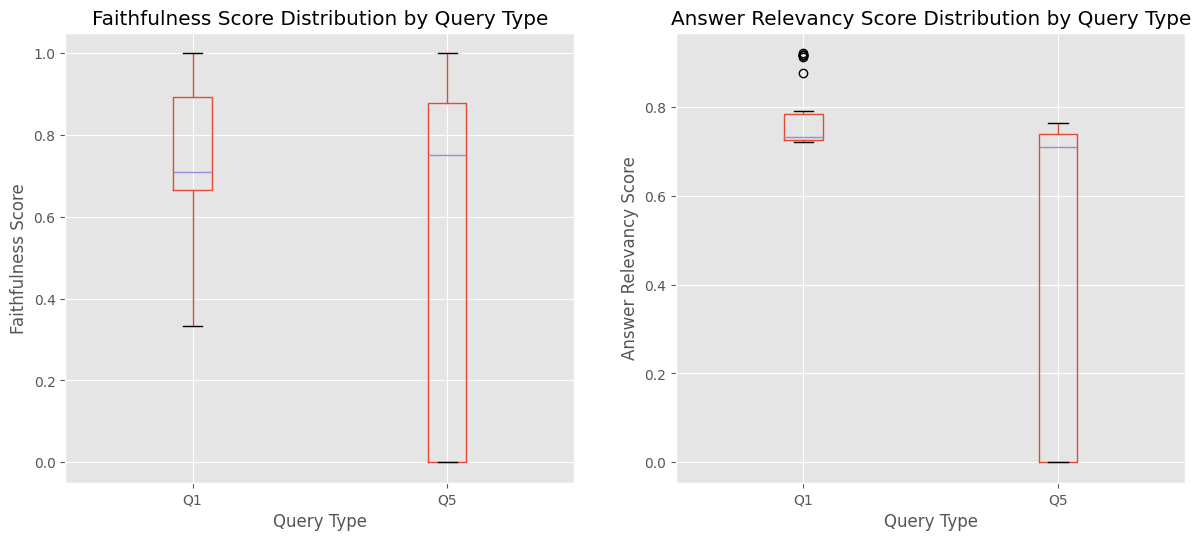

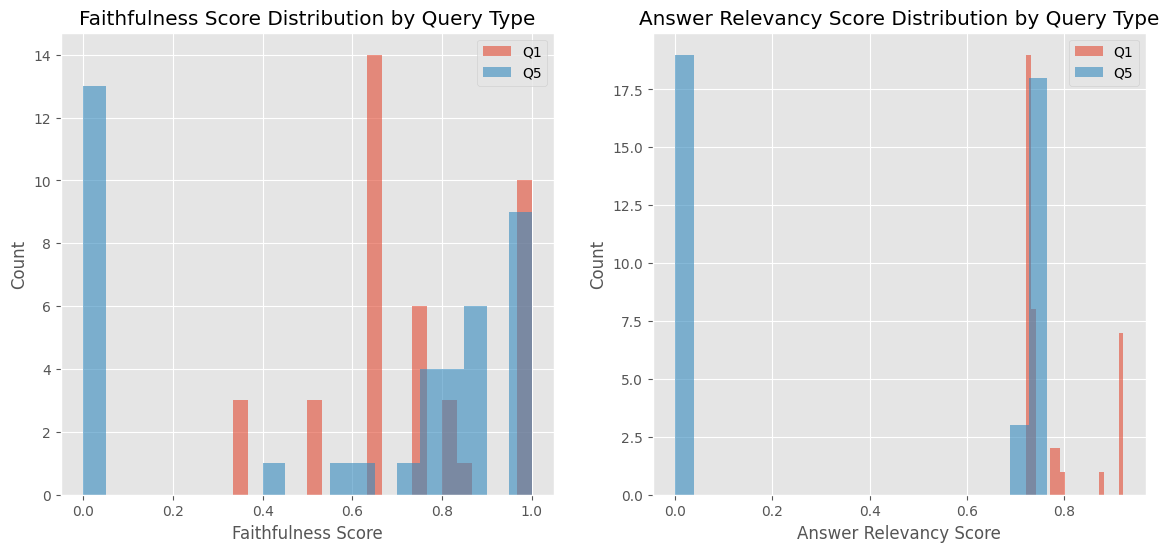

In [46]:
# plot summary statistics for generation evaluation

# Set plot style for better readability
plt.style.use("ggplot")

# Create boxplots for Faithfulness and Answer Relevancy per Query Type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Faithfulness Boxplot
evaluation_results_relevanceFaithfulness.boxplot(column="faithfulness", by="query_type", ax=axes[0])
axes[0].set_title("Faithfulness Score Distribution by Query Type")
axes[0].set_xlabel("Query Type")
axes[0].set_ylabel("Faithfulness Score")

# Answer Relevancy Boxplot
evaluation_results_relevanceFaithfulness.boxplot(column="answer_relevancy", by="query_type", ax=axes[1])
axes[1].set_title("Answer Relevancy Score Distribution by Query Type")
axes[1].set_xlabel("Query Type")
axes[1].set_ylabel("Answer Relevancy Score")

plt.suptitle("")  # Remove default Matplotlib title
plt.show()

# Create histograms for Faithfulness and Answer Relevancy per Query Type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Faithfulness Histogram
for query in evaluation_results_relevanceFaithfulness["query_type"].unique():
    subset = evaluation_results_relevanceFaithfulness[evaluation_results_relevanceFaithfulness["query_type"] == query]["faithfulness"]
    axes[0].hist(subset, bins=20, alpha=0.6, label=query)

axes[0].set_title("Faithfulness Score Distribution by Query Type")
axes[0].set_xlabel("Faithfulness Score")
axes[0].set_ylabel("Count")
axes[0].legend()

# Answer Relevancy Histogram
for query in evaluation_results_relevanceFaithfulness["query_type"].unique():
    subset = evaluation_results_relevanceFaithfulness[evaluation_results_relevanceFaithfulness["query_type"] == query]["answer_relevancy"]
    axes[1].hist(subset, bins=20, alpha=0.6, label=query)

axes[1].set_title("Answer Relevancy Score Distribution by Query Type")
axes[1].set_xlabel("Answer Relevancy Score")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.show()


In [64]:
# Adjust column names based on actual content
expected_columns = ["query_type", "faithfulness", "answer_relevancy", "context_relevancy"]
df = evaluation_results_relevanceFaithfulness[[col for col in expected_columns if col in evaluation_results_relevanceFaithfulness.columns]]
df_onlywithdwellings = evaluation_results_relevanceFaithfulness[evaluation_results_relevanceFaithfulness['retrieved_contexts'].apply(lambda x: x != [])]

# Group by query type (Q1 vs Q5) and compute summary statistics
grouped = df_onlywithdwellings.groupby("query_type").agg(
    faithfulness_mean=("faithfulness", "mean"),
    faithfulness_median=("faithfulness", "median"),
    faithfulness_std=("faithfulness", "std"),
    relevance_mean=("answer_relevancy", "mean"),
    relevance_median=("answer_relevancy", "median"),
    relevance_std=("answer_relevancy", "std")
).reset_index()


### End-to-End Manual Evaluation

In [6]:
# script for manually labelling the end-to-end generated answers
import json

with open ("chunks_backup/backup_chunks_allSmall0311_onlyText.json", "r", encoding="utf-8") as json_file:
    all_chunks = json.load(json_file)



# Load JSON dictionary and all_chunks list
with open('Evaluation/filtered_ground_truth_40plans_Q1Q5_voyage3lite10ktop0.2similarity_RetrievalGeneration_0316.json', 'r', encoding='utf-8') as f:
    answers_dict = json.load(f)

# Create a lookup dictionary for chunk text
chunk_text_lookup = {chunk['chunk_id']: chunk['text'] for chunk in all_chunks}

# Iterate through queries and print results
for plan in answers_dict["plans"]:
    plan_number = plan["plan_number"]
    print(f"\nPlan Number: {plan_number}")
    
    for query in plan["queries"]:
        query_id = query['query_id']
        query_text = query['query_text']
        generated_answer=query.get("generated_answer", "No generated answer found")
        correct_answer=query["correct_answer_manual"]

        print(f"\nQuery ID: {query_id}")
        print(f"Query Text: {query_text}")
        print(f"Generated Answer: {generated_answer}")
        print(f"Correct Answer: {correct_answer}")

        # #retrieve relevant chunks text
        # print("\nRetrieved Chunks Text:")
        # for chunk in query["relevant_chunks_manual"]:
        #     chunk_id = chunk["chunk_id"]
        #     chunk_text = chunk_text_lookup.get(chunk_id, "Chunk text not found")
        #     print(f"\nChunk ID: {chunk_id}")
        #     print(f"Chunk Heading: {chunk['chunk_heading']}")
        #     print(f"Chunk Text: {chunk_text}")
            
        # Manual labeling
        while True:
            print(f"checking for {query_id}")
            label = input("Is this answer correct? (y/n): ").strip().lower()
            if label in ['y', 'n']:
                query['label'] = 'correct' if label == 'y' else 'incorrect'
                break
            else:
                print("Invalid input. Please enter 'y' or 'n'.")
        
# Save labeled data
with open('labeled_answers.json', 'w', encoding='utf-8') as f:
    json.dump(answers_dict, f, ensure_ascii=False, indent=4)

print("\nLabeling complete. Labeled answers saved in 'labeled_answers.json'.")


Plan Number: 507-0810747

Query ID: 1
Query Text: מה שטח התכנית בדונם?
Generated Answer: Based on the context provided, the area of the plan (שטח התכנית) is 15.140 dunams (דונם).
Correct Answer: 15.140
checking for 1

Query ID: 5
Query Text: ?כמה יחידות דיור מתוכננות בתכנית
Generated Answer: Based on the provided context, the planned number of housing units in this plan is as follows:

- Maximum number of housing units: 365
- This includes:
  - Regular housing units
  - Affordable housing units

However, it's important to note:

1. If all affordable housing units are not implemented, the maximum number of housing units will be reduced to 280.

2. The final number and mix of units will be determined during the architectural design approval stage by the city engineer or their representative.

3. The plan allows for the conversion of areas designated for affordable housing to office use or leisure and entertainment use, which could potentially reduce the total number of housing units.

4

In [7]:
import json

# Load the labeled answers
with open('labeled_answers.json', 'r', encoding='utf-8') as f:
    labeled_data = json.load(f)

# Initialize counters
query_stats = {}
total_correct = 0
total_queries = 0

# Process data
for plan in labeled_data["plans"]:
    for query in plan["queries"]:
        query_id = query["query_id"]
        
        if "label" in query:  # Only count labeled queries
            if query_id not in query_stats:
                query_stats[query_id] = {"Total Queries": 0, "Correct": 0}

            query_stats[query_id]["Total Queries"] += 1
            total_queries += 1

            if query["label"] == "correct":
                query_stats[query_id]["Correct"] += 1
                total_correct += 1

# Compute accuracy per Query ID
for query_id, stats in query_stats.items():
    stats["Accuracy (%)"] = round((stats["Correct"] / stats["Total Queries"]) * 100, 2)

# Compute overall accuracy
overall_accuracy = round((total_correct / total_queries) * 100, 2) if total_queries > 0 else 0

# Print summary
print("\n=== Labeling Accuracy Per Query ID ===")
for query_id, stats in sorted(query_stats.items()):
    print(f"\nQuery ID {query_id}:")
    print(f"  Total Occurrences: {stats['Total Queries']}")
    print(f"  Correct: {stats['Correct']}")
    print(f"  Accuracy: {stats['Accuracy (%)']}%")

print("\n=== Overall Accuracy ===")
print(f"Total Queries Labeled: {total_queries}")
print(f"Total Correct: {total_correct}")
print(f"Overall Accuracy: {overall_accuracy}%")



=== Labeling Accuracy Per Query ID ===

Query ID 1:
  Total Occurrences: 40
  Correct: 40
  Accuracy: 100.0%

Query ID 5:
  Total Occurrences: 40
  Correct: 32
  Accuracy: 80.0%

=== Overall Accuracy ===
Total Queries Labeled: 80
Total Correct: 72
Overall Accuracy: 90.0%
